# import

In [15]:
# === iPython Config ===
from IPython import get_ipython
if 'IPython.extensions.autoreload' not in get_ipython().extension_manager.loaded:
    get_ipython().run_line_magic('load_ext', 'autoreload')
else:
    get_ipython().run_line_magic('reload_ext', 'autoreload')
%autoreload 2

# === System and Path ===
import os
import sys
repo_path = os.path.dirname(os.getcwd())
if repo_path not in sys.path:
    sys.path.append(repo_path)
import warnings
warnings.filterwarnings('ignore')

# === Import libraries ===
import pandas as pd
import numpy as np

In [16]:
# === Load data ===
file_path = os.path.join(repo_path, "final-project", "data", "raw.xlsx")
df_raw = pd.read_excel(file_path)

In [17]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214950 entries, 0 to 214949
Data columns (total 19 columns):
 #   Column                         Non-Null Count   Dtype 
---  ------                         --------------   ----- 
 0   ชื่อเทศกาล                     214950 non-null  object
 1   รหัสจังหวัด                    214950 non-null  int64 
 2   จังหวัด                        214950 non-null  object
 3   รหัส รพ.                       214950 non-null  int64 
 4   ชื่อโรงพยาบาลที่รับผู้บาดเจ็บ  214950 non-null  object
 5   วันที่เกิดเหตุ                 214950 non-null  int64 
 6   เวลาเกิดเหตุ                   214950 non-null  object
 7   เพศ                            214950 non-null  object
 8   อายุ                           214950 non-null  int64 
 9   ถนนที่เกิดเหตุ                 214950 non-null  object
 10  สถานะ                          214950 non-null  object
 11  รถผู้บาดเจ็บ                   214950 non-null  object
 12  รถคู่กรณี                      214950 non-nu

# Data cleaning

In [18]:
def clean_duplicate_rows(df):
    print("=== Cleaning Duplicate Rows ===")
    dup_count = df.duplicated().sum()
    print(f"Duplicate records: {dup_count}")
    df = df.drop_duplicates()
    print(f"Remaining records after removing duplicates: {df.shape[0]}")
    return df

df_cleaned = clean_duplicate_rows(df_raw)

=== Cleaning Duplicate Rows ===
Duplicate records: 1186
Remaining records after removing duplicates: 213764


In [19]:
def clean_age_validity(df):
    print("=== Cleaning Age Validity ===")
    print(f"Records with age = 0: {df[df['อายุ'] == 0].shape[0]}")
    df = df[df['อายุ'] > 0]
    print(f"Remaining records after removing age = 0: {df.shape[0]}")
    return df

df_cleaned = clean_age_validity(df_cleaned)

=== Cleaning Age Validity ===
Records with age = 0: 3912
Remaining records after removing age = 0: 209852


In [20]:
def create_survival_label(df):
    """
    Create a binary 'survived' column:
    - 1 if 'ผลการรักษา' == 'ทุเลา/หาย'
    - 0 otherwise (any form of death)
    """
    print("=== Creating 'survived' column ===")
    df['survived'] = (df['ผลการรักษา'] == 'ทุเลา/หาย').astype(int)
    print(df['survived'].value_counts())
    # drop the 'ผลการรักษา' column
    print("=== Dropping 'ผลการรักษา' column ===")
    df = df.drop(columns=['ผลการรักษา'])
    return df

df_cleaned = create_survival_label(df_cleaned)

=== Creating 'survived' column ===
survived
1    206365
0      3487
Name: count, dtype: int64
=== Dropping 'ผลการรักษา' column ===


In [21]:
def clean_datetime(df):
    """
    Combines 'ชื่อเทศกาล', 'วันที่เกิดเหตุ', and 'เวลาเกิดเหตุ' into a new datetime column.
    Uses the year from 'ชื่อเทศกาล', the numeric day, and the start time from the time range.
    Drops rows with 'ไม่ทราบ' in 'เวลาเกิดเหตุ'.
    """
    from datetime import datetime
    import re

    print("=== Cleaning and Combining to 'datetime' ===")

    # Extract 'year' from festival string
    df['year'] = df['ชื่อเทศกาล'].str.extract(r'ปีใหม่\s*(\d{2})').astype(float) + 2500 - 543
    df['year'] = df['year'].astype(int)
    df.drop(columns=['ชื่อเทศกาล'], inplace=True)
    print("Dropped 'ชื่อเทศกาล' column.")

    # Rename 'วันที่เกิดเหตุ' to 'day_of_month'
    df.rename(columns={'วันที่เกิดเหตุ': 'day_of_month'}, inplace=True)
    # validate day_of_month is 1-31
    # print(df[~df['day_of_month'].isin(range(1, 32))])
    df = df[df['day_of_month'].isin(range(1, 32))]

    # New column 'month'
    # if day_of_month is 1-15, month is 1, else month is 12
    df['month'] = df['day_of_month'].apply(lambda x: 1 if x <= 15 else 12)

    # Clean time format and extract 'start_time'
    def extract_start_time(time_str):
        if not isinstance(time_str, str) or 'ไม่ทราบ' in time_str:
            return None
        time_str = re.sub(r'[^0-9:\-]', '', time_str)
        try:
            # special_case: if time_str is start with 24, minus 24
            if time_str.startswith('24'):
                time_str = time_str.replace('24', '00')
            return time_str.split('-')[0][:2]
        except:
            return None
    df['hour'] = df['เวลาเกิดเหตุ'].apply(extract_start_time)
    print("Extracted 'hour' column.")
    df.drop(columns=['เวลาเกิดเหตุ'], inplace=True)
    print("Dropped 'เวลาเกิดเหตุ' columns.")

    # Drop 'year' column
    df.drop(columns=['year'], inplace=True)
    print("Dropped 'year' column.")

    return df

df_cleaned = clean_datetime(df_cleaned)

=== Cleaning and Combining to 'datetime' ===
Dropped 'ชื่อเทศกาล' column.
Extracted 'hour' column.
Dropped 'เวลาเกิดเหตุ' columns.
Dropped 'year' column.


In [22]:
def clean_gender(df, column='เพศ'):
    """
    Converts Thai gender column to binary 'sex' column.
    'ชาย' → 1 (male), 'หญิง' → 0 (female)
    """
    gender_map = {'ชาย': 1, 'หญิง': 0}
    df['sex'] = df[column].map(gender_map)
    df.drop(columns=[column], inplace=True)
    print("Converted 'เพศ' and droped to new binary 'sex' column.")
    return df

df_cleaned = clean_gender(df_cleaned)

Converted 'เพศ' and droped to new binary 'sex' column.


In [23]:
def clean_use_id_instead(df):
    """
    Drop 'จังหวัด' and 'ชื่อโรงพยาบาลที่รับผู้บาดเจ็บ' cols.
    'จังหวัด' use-> 'รหัสจังหวัด'
    'ชื่อโรงพยาบาลที่รับผู้บาดเจ็บ' use-> 'รหัส รพ.'
    """
    # drop 'จังหวัด' 'ชื่อโรงพยาบาลที่รับผู้บาดเจ็บ' cols
    df.drop(columns=['จังหวัด', 'ชื่อโรงพยาบาลที่รับผู้บาดเจ็บ'], inplace=True)
    print("Dropped 'จังหวัด' and 'ชื่อโรงพยาบาลที่รับผู้บาดเจ็บ' columns.")
    return df

df_cleaned = clean_use_id_instead(df_cleaned)

Dropped 'จังหวัด' and 'ชื่อโรงพยาบาลที่รับผู้บาดเจ็บ' columns.


In [24]:
def print_unique_values_per_column(df):
    """
    Prints the unique values for each column in the given DataFrame.

    Args:
        df (pd.DataFrame): The DataFrame to process.
    """
    for column in df.columns:
        print(f"Unique values for column '{column}':")
        print(df[column].unique())
        print("-" * 30) # Separator for readability

# Example usage (assuming df_cleaned is your DataFrame):
print_unique_values_per_column(df_cleaned)

Unique values for column 'รหัสจังหวัด':
[10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 30 31 32 33 34 35
 36 37 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 60 61
 62 63 64 65 66 67 70 71 72 73 74 75 76 77 80 81 82 83 84 85 86 90 91 92
 93 94 95 96 97]
------------------------------
Unique values for column 'รหัส รพ.':
[11630 11548 11616 ... 15693 24300 28817]
------------------------------
Unique values for column 'day_of_month':
[ 3  2 30 31 29  1 28  4  5 27]
------------------------------
Unique values for column 'อายุ':
[54 13 81 35 22 27 31 26 45 59 41 42 21 28 17 16 19 20 39 34 58 44 15 33
 32 29 25 18 24 50 65 30 62 11 23 36 53  3 51  2 38 64 55 40 46 52 88 71
 63 69  6 43 48 47  9  8 10 12 56  7 61 37 14 60 67 57 70  4 87  5 49  1
 83 82 78 66 72 80 77 68 84 98 74 73 85 79 99 76 75 92 96 89 93 86 97 90
 91 94 95]
------------------------------
Unique values for column 'ถนนที่เกิดเหตุ':
['ในเมือง' 'ไม่ทราบ' 'ทางหลวง' 'ชนบท']
------------------------------

In [25]:
def print_column_value_counts(df, top_n=None):
    """
    Prints unique value counts for each column in the DataFrame.

    Args:
        df (pd.DataFrame): The DataFrame to analyze.
        top_n (int, optional): If specified, limits output to top N most frequent values per column.
    """
    for col in df.columns:
        print(f"--- Column: '{col}' ---")
        value_counts = df[col].value_counts(dropna=False)
        if top_n is not None:
            value_counts = value_counts.head(top_n)
        print(value_counts)
        print("-" * 40)

print_column_value_counts(df_cleaned)

--- Column: 'รหัสจังหวัด' ---
รหัสจังหวัด
30    9686
50    7716
20    7051
40    6607
31    6022
      ... 
91     765
23     764
37     761
75     558
97     516
Name: count, Length: 77, dtype: int64
----------------------------------------
--- Column: 'รหัส รพ.' ---
รหัส รพ.
10819    1726
10741    1395
10670    1217
10666    1206
10682    1123
         ... 
14612       1
12057       1
11961       1
12244       1
11901       1
Name: count, Length: 1204, dtype: int64
----------------------------------------
--- Column: 'day_of_month' ---
day_of_month
31    40981
1     38582
30    34475
2     24279
29    22394
3     15928
4     11749
28    11260
27     6112
5      4091
Name: count, dtype: int64
----------------------------------------
--- Column: 'อายุ' ---
อายุ
17    8780
18    8705
16    8537
15    7851
19    7641
      ... 
91       3
94       3
92       2
95       2
96       1
Name: count, Length: 99, dtype: int64
----------------------------------------
--- Column: 'ถนนที่เกิดเหตุ'

# data preprocessing

  0%|          | 0/11 [00:00<?, ?it/s]

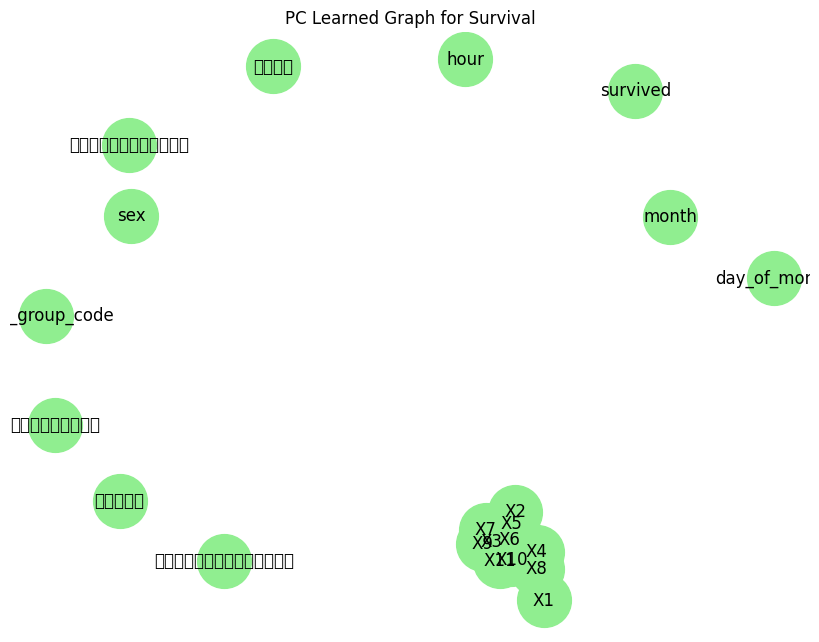

Direct parents of 'survived': []

Ranked Average Causal Effects (ACE) on survival:


In [29]:
import pandas as pd
import numpy as np
from dowhy import CausalModel
# from dowhy.dowhy import graphs
from causallearn.search.ConstraintBased.PC import pc
from causallearn.utils.GraphUtils import GraphUtils
# from causallearn.utils import draw_graph

import matplotlib.pyplot as plt

# Q1: Causal discovery + causal effect estimation using DoWhy (per Molak, 2023)
# Assume df_cleaned is loaded
df = df_cleaned.copy()

# 1. Prepare pre-treatment variables
df['hour'] = pd.to_numeric(df['hour'], errors='coerce')
df['day_of_month'] = pd.to_numeric(df['day_of_month'], errors='coerce')
df['month'] = pd.to_numeric(df['month'], errors='coerce')

# Define age bins and labels
bins = [0, 15, 25, 40, 60, 100]  # You can modify based on your data range
labels = ['child', 'young_adult', 'adult', 'middle_age', 'senior']

# Add a new column for binned age
df['age_group'] = pd.cut(df['อายุ'], bins=bins, labels=labels, right=False)

# (Optional) Convert to numeric codes if needed for PC algorithm
df['age_group_code'] = pd.Categorical(df['age_group']).codes


# Treatments/covariates of interest
vars_of_interest = [
    'อายุ', 'sex', 'hour', 'month', 'day_of_month',
    'ถนนที่เกิดเหตุ', 'สถานะ', 'รถผู้บาดเจ็บ', 'รถคู่กรณี', 'age_group_code'
]
# Encode categoricals for discovery
df_disc = df[vars_of_interest + ['survived']].dropna()
for col in vars_of_interest:
    if df_disc[col].dtype == object:
        df_disc[col] = pd.Categorical(df_disc[col]).codes

data_matrix = df_disc.values

# 2. Causal discovery via PC algorithm
pc_result = pc(data_matrix, alpha=0.05)
G_pc = pc_result.G  # Causal graph object
# Convert and plot
# g = GraphUtils.to_nx_graph(G_pc, df_disc.columns.tolist())
import networkx as nx

def convert_to_nx_graph(G_pc, variable_names):
    g_nx = nx.DiGraph()
    for i in range(len(variable_names)):
        g_nx.add_node(i, label=variable_names[i])
    for edge in G_pc.get_graph_edges():
        g_nx.add_edge(edge.node1, edge.node2)
    return nx.relabel_nodes(g_nx, {i: variable_names[i] for i in range(len(variable_names))})


g = convert_to_nx_graph(G_pc, df_disc.columns.tolist())

plt.figure(figsize=(8,6))
nx.draw(g, with_labels=True, node_size=1500, node_color='lightgreen')
plt.title('PC Learned Graph for Survival')
plt.show()
# 3. Identify direct causes of 'survived'
# direct_parents = [u for u, v in G_pc.get_graph_edges() if v == df_disc.columns.get_loc('survived')]
direct_parents = [edge.node1 for edge in G_pc.get_graph_edges() if edge.node2 == df_disc.columns.get_loc('survived')]

parent_vars = [df_disc.columns[i] for i in direct_parents]
print("Direct parents of 'survived':", parent_vars)

# 4. Causal effect estimation for each parent
effects = {}
for parent in parent_vars:
    # Setup causal model per Molak§3.2
    model = CausalModel(
        data=df_disc.rename(columns={parent: 'treat'}).assign(survived=df_disc['survived']),
        treatment='treat', outcome='survived',
        common_causes=[v for v in vars_of_interest if v != parent]
    )
    identified = model.identify_effect(proceed_when_unidentifiable=False)
    est = model.estimate_effect(identified, method_name="backdoor.propensity_score_matching")
    effects[parent] = est.value

# 5. Rank factors by causal ACE magnitude
ranked = sorted(effects.items(), key=lambda x: abs(x[1]), reverse=True)
print("\nRanked Average Causal Effects (ACE) on survival:")
for var, ace in ranked:
    print(f"- {var}: ACE = {ace:.3f}")
